In [1]:
import numpy as np
import pandas as pd 
import scipy as sp
import scipy.io
from scipy.stats import norm
from scipy.stats import multivariate_normal
from scipy.signal import find_peaks
from datetime import datetime


import matplotlib.pyplot as plt
import matplotlib.colors as mcolors



import os
import glob
import fnmatch
import re


## Read Arapuca run log 

In [2]:
df_Xerunlist = pd.read_csv('./XeArapucaRunList.csv', sep = ';')
df_Xerunlist.head()

,Run Number,Config,Day/time,Comments,Efield
0,10872,CRT_noprescale_delay_Feb00003,06/02/2020,First run after solving the noise problem. All...,False
1,10873,CRT_noprescale_delay_Feb00003,06/02/2020,Started using CRT trigger. Biases for channels...,False
2,10874,CRT_noprescale_delay_Feb00003,06/02/2020,"Biases for channels 0,6 and 8 to 11 of SSP 504...",False
3,10875,CRT_noprescale_delay_Feb00003,06/02/2020,Biases for channels 0 to 7 of SSP 504 brought ...,False
4,10877,XeDope_CRT_noprescale_delay_Feb00002,06/02/2020,New config with lower disc thresholds (70 ADC ...,False


In [3]:
df_Xerunlist_info = df_Xerunlist[['Run Number', 'Day/time', 'Efield']]
df_Xerunlist_info['Day/time'] = pd.to_datetime(df_Xerunlist_info['Day/time'], format='%d/%m/%Y')
df_Xerunlist_info['Day/time'] = df_Xerunlist_info['Day/time'].dt.strftime('%d %b')
df_Xerunlist_info.head()

,Run Number,Day/time,Efield
0,10872,06 Feb,False
1,10873,06 Feb,False
2,10874,06 Feb,False
3,10875,06 Feb,False
4,10877,06 Feb,False


## Read my files and do the analysis

In [4]:
# read APA 6 files 

base_path_mod603 = '/Users/bordoni/protoDUNE/XeDoping/Arapuca/fnal_results/infiles08052020_mod603'
file_path_mod603 = os.path.join(base_path_mod603,'CalibratedIntegral_*.csv')

file_name_list_mod603 =  glob.glob(file_path_mod603) 
print(' Getting infos from ', len(file_name_list_mod603), 'runs ')

Getting infos from  51 runs 


In [5]:
# read APA 3 files 

base_path_mod304 = '/Users/bordoni/protoDUNE/XeDoping/Arapuca/fnal_results/infiles08052020_mod304'
file_path_mod304 = os.path.join(base_path_mod304,'CalibratedIntegral_*.csv')

file_name_list_mod304 =  glob.glob(file_path_mod304) 
print(' Getting infos from ', len(file_name_list_mod304), 'runs ')

Getting infos from  74 runs 


In [6]:
def readfile_list(filename_list):       
    
    def read_single_file(f):
        #load the file as a np array
        #data = pd.read_csv(f, header=0, usecols=[1,2] , names = ['Run number', 'Integral'])
        data = pd.read_csv(f, index_col=0)
        return data
    
    data_list = [read_single_file(f) for f in filename_list]
    return pd.concat(data_list, axis=0)

In [7]:
df_603 = readfile_list(file_name_list_mod603)
df_603.head()

,Run number,Ch,Integral,pe area_mean,pe area_std,f_cal,n good evts
0,11021,0,5534.322105,438.797034,144.886754,1.000000,6804
1,11021,1,14117.131841,450.359705,152.530278,1.026351,2504
2,11021,2,13022.030469,448.850498,143.627997,1.022911,2385
3,11021,3,15045.207965,415.431604,156.352321,0.946751,2247
4,11021,4,7202.065870,444.835992,145.092221,1.013763,6747


In [8]:
df_304 = readfile_list(file_name_list_mod304)
df_304.head()

,Run number,Ch,Integral,pe area_mean,pe area_std,f_cal,n good evts
0,11021,0,7554.093236,475.629607,164.225912,1.000000,10620
1,11021,1,5965.158716,473.798684,163.436650,0.996151,10694
2,11021,2,6811.382174,478.290037,163.970221,1.005593,10659
3,11021,3,5707.479941,491.526595,165.134200,1.033423,10700
4,11021,4,13929.721287,477.829584,163.054736,1.004625,4830


In [9]:
#create df apa6 for the integral

df_integral_603 = df_603.groupby(['Run number'])['Integral'].sum().to_frame().reset_index()
stat  = np.sqrt(df_603.groupby(['Run number'])['n good evts'].sum())
df_integral_603['stat err'] = stat.values
df_integral_603.rename(columns={'Run number': 'Run Number'}, inplace=True)
df_integral_603.head()

,Run Number,Integral,stat err
0,10906,117264.588563,80.901174
1,10907,136793.434553,125.582642
2,10909,127661.812705,76.111760
3,10912,169646.176015,52.640289
4,10915,167335.857995,54.304696


In [10]:
df_apa6 = pd.merge(df_Xerunlist_info, df_integral_603, how = 'inner', on=['Run Number'])
df_apa6.head()

,Run Number,Day/time,Efield,Integral,stat err
0,10906,09 Feb,False,117264.588563,80.901174
1,10907,09 Feb,False,136793.434553,125.582642
2,10909,09 Feb,False,127661.812705,76.111760
3,10915,10 Feb,False,167335.857995,54.304696
4,10922,10 Feb,False,140715.673310,38.223030


In [11]:
#create df apa3 for the integral

df_integral_304 = df_304.groupby(['Run number'])['Integral'].sum().to_frame().reset_index()
stat  = np.sqrt(df_304.groupby(['Run number'])['n good evts'].sum())
df_integral_304['stat err'] = stat.values
df_integral_304.rename(columns={'Run number': 'Run Number'}, inplace=True)
df_integral_304.head()

,Run Number,Integral,stat err
0,10877,143112.006752,167.263266
1,10878,134258.434941,177.208916
2,10879,146913.710598,163.000000
3,10885,138948.518489,142.635900
4,10903,142025.626576,163.187009


In [12]:
df_apa3 = pd.merge(df_Xerunlist_info, df_integral_304, how = 'inner', on=['Run Number'])
df_apa3.head()

,Run Number,Day/time,Efield,Integral,stat err
0,10877,06 Feb,False,143112.006752,167.263266
1,10878,06 Feb,False,134258.434941,177.208916
2,10879,06 Feb,False,146913.710598,163.000000
3,10885,07 Feb,False,138948.518489,142.635900
4,10903,08 Feb,False,142025.626576,163.187009


In [13]:
# check if there are runs with EField ON
print(' Checking if there are runs for APA6  with Efield ON : ' )
display(df_apa6['Efield'].value_counts() )

print(' Checking if there are runs for APA3  with Efield ON : ' )
display(df_apa3['Efield'].value_counts() )

df_apa6_efieldON = df_apa6.loc[(df_apa6['Efield'] ==True)]
#display(df_apa6_efieldON.shape)

df_apa6_efieldOFF = df_apa6.loc[(df_apa6['Efield'] ==False)]

df_apa3_efieldON = df_apa3.loc[(df_apa3['Efield'] ==True)]
df_apa3_efieldOFF = df_apa3.loc[(df_apa3['Efield'] ==False)]




Checking if there are runs for APA6  with Efield ON : 


False    45
Name: Efield, dtype: int64

Checking if there are runs for APA3  with Efield ON : 


False    66
True      2
Name: Efield, dtype: int64

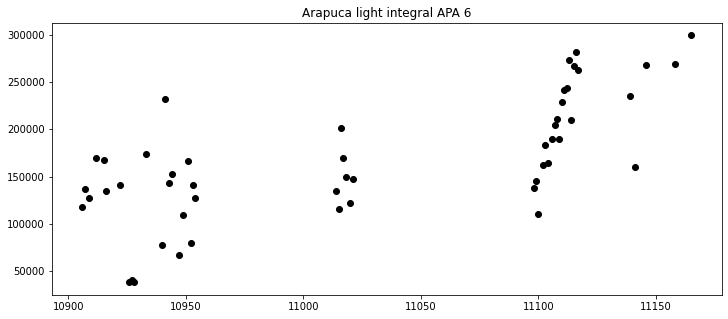

In [15]:
plt.figure(figsize=(12,5))

plt.title('Arapuca light integral APA 6')
plt.errorbar(x=df_integral_603['Run Number'], y=df_integral_603['Integral'], yerr=df_integral_603['stat err'], 
            fmt='o', color='black', ecolor='lightgray', elinewidth=3, capsize=0)
plt.show()

            

## Plot APA 3 and APA 6 integrals as a function of the time

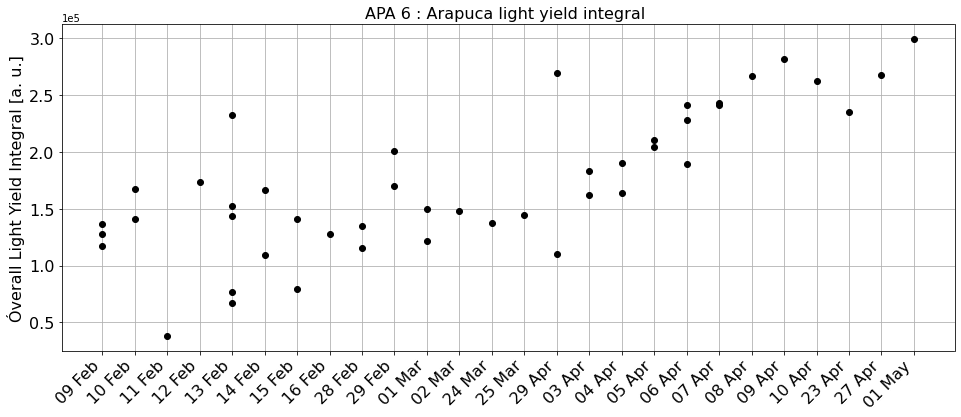

In [18]:
############################################################
#                           APA 6 
############################################################
plt.figure(figsize=(16,6))

plt.title('APA 6 : Arapuca light yield integral ', fontsize=16)
plt.errorbar(x=df_apa6_efieldOFF['Day/time'], y=df_apa6_efieldOFF['Integral'], yerr=np.sqrt(df_apa6_efieldOFF['stat err']), 
            fmt='o', color='black', ecolor='lightgray', elinewidth=3, capsize=0)

plt.ylabel('Óverall Light Yield Integral [a. u.]', fontsize=16)
plt.ticklabel_format(axis='y', style="sci", scilimits=(0,0))
plt.xticks(rotation=45, fontsize=16, horizontalalignment="right")
plt.yticks(fontsize=16)


plt.grid()
plt.show()

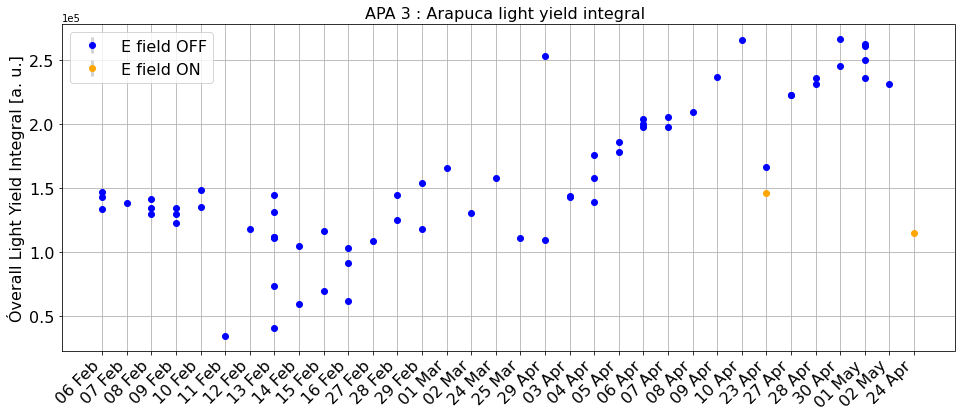

In [19]:
############################################################
#                           APA 3 
############################################################
plt.figure(figsize=(16,6))

plt.title('APA 3 : Arapuca light yield integral ', fontsize=16)
plt.errorbar(x=df_apa3_efieldOFF['Day/time'], y=df_apa3_efieldOFF['Integral'], yerr=np.sqrt(df_apa3_efieldOFF['stat err']), 
            fmt='o', color='blue', ecolor='lightgray', elinewidth=3, capsize=0, label = 'E field OFF')

plt.errorbar(x=df_apa3_efieldON['Day/time'], y=df_apa3_efieldON['Integral'], yerr=np.sqrt(df_apa3_efieldON['stat err']), 
            fmt='o', color='orange', ecolor='lightgray', elinewidth=3, capsize=0, label = 'E field ON')


plt.ylabel('Óverall Light Yield Integral [a. u.]', fontsize=16)
plt.ticklabel_format(axis='y', style="sci", scilimits=(0,0))
plt.xticks(rotation=45, fontsize=16, horizontalalignment="right")
plt.yticks(fontsize=16)

plt.legend(fontsize=16)

plt.grid()
plt.show()

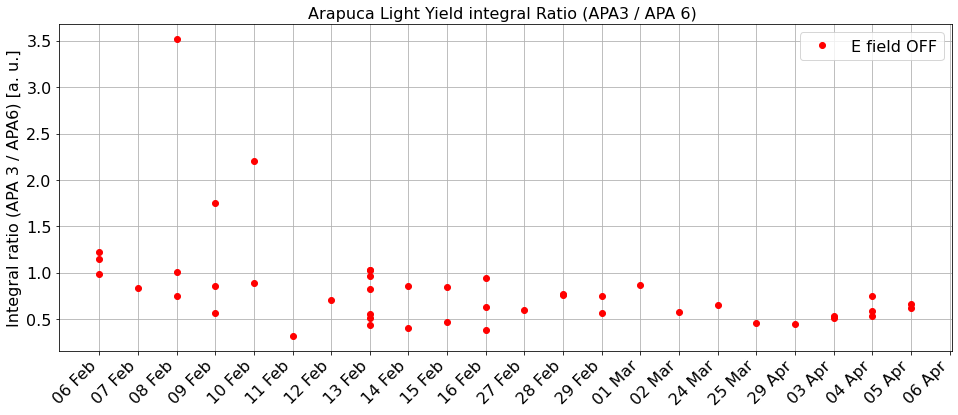

In [20]:
############################################################
#                           RATIO APA 6 / APA 3 
############################################################


plt.figure(figsize=(16,6))

plt.title('Arapuca Light Yield integral Ratio (APA3 / APA 6) ', fontsize=16)
plt.errorbar(x=df_apa3_efieldOFF['Day/time'], y=df_apa3_efieldOFF['Integral']/df_apa6_efieldOFF['Integral'], fmt='o', color='red', ecolor='lightgray', elinewidth=3, capsize=0, label = 'E field OFF')



plt.ylabel('Integral ratio (APA 3 / APA6) [a. u.]', fontsize=16)
plt.ticklabel_format(axis='y', style="sci", scilimits=(0,0))
plt.xticks(rotation=45, fontsize=16, horizontalalignment="right")
plt.yticks(fontsize=16)

plt.legend(fontsize=16)

plt.grid()
plt.show()




## Do plots against X-Arapuca

In [31]:
df_XA = pd.read_csv('./XArapuca_IntegralsSPE.txt', sep= ' ', header=None, index_col=0, names=['W/O quartz', 'W quartz', 'Date', 'Time'])

df_XA['Date'] = pd.to_datetime(df_XA['Date'], format='%Y:%m:%d')
df_XA['Date'] = df_XA['Date'].dt.strftime('%d %b')

df_XA.head()

,W/O quartz,W quartz,Date,Time
0,39.4964,3.66560,13 Feb,18:40:27
1,50.4461,7.94902,13 Feb,18:45:23
2,106.6290,10.26250,13 Feb,18:48:59
3,154.1550,24.46120,13 Feb,19:05:00
4,102.9690,18.79770,13 Feb,19:27:47


In [36]:
# create data frame with both XA infos and APA 3 (APA 6)

df_XA_vs_APA3 = pd.merge(df_XA, df_apa3, how = 'inner', left_on=['Date'], right_on='Day/time')

df_XA_vs_APA6 = pd.merge(df_XA, df_apa6, how = 'inner', left_on=['Date'], right_on='Day/time')


df_XA_vs_APA6.head()


,W/O quartz,W quartz,Date,Time,Run Number,Day/time,Efield,Integral,stat err
0,39.4964,3.6656,13 Feb,18:40:27,10940,13 Feb,False,77186.889488,64.892218
1,39.4964,3.6656,13 Feb,18:40:27,10941,13 Feb,False,232205.079817,33.361655
2,39.4964,3.6656,13 Feb,18:40:27,10943,13 Feb,False,143452.746462,37.881394
3,39.4964,3.6656,13 Feb,18:40:27,10944,13 Feb,False,152623.571707,52.163205
4,39.4964,3.6656,13 Feb,18:40:27,10947,13 Feb,False,67262.557810,91.279790


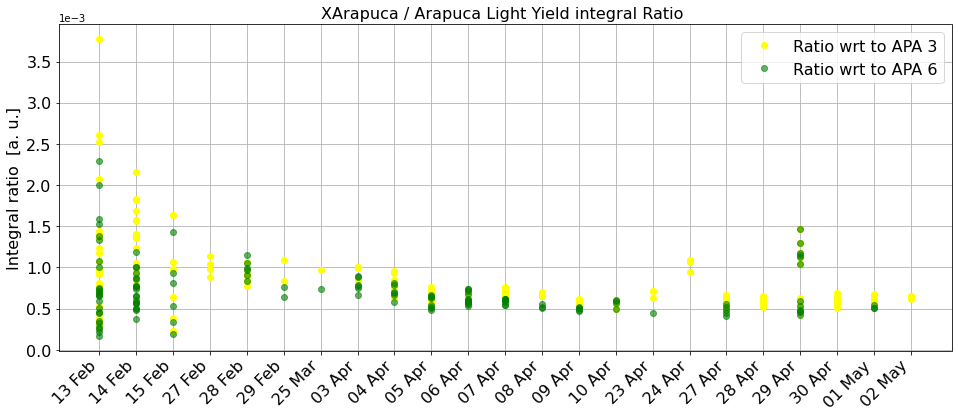

In [41]:
plt.figure(figsize=(16,6))

plt.title('XArapuca / Arapuca Light Yield integral Ratio ', fontsize=16)
plt.errorbar(x=df_XA_vs_APA3['Day/time'], y=df_XA_vs_APA3['W/O quartz']/df_XA_vs_APA3['Integral'], fmt='o', color='yellow', ecolor='lightgray', elinewidth=3, capsize=0, label = 'Ratio wrt to APA 3')

plt.errorbar(x=df_XA_vs_APA6['Day/time'], y=df_XA_vs_APA6['W/O quartz']/df_XA_vs_APA6['Integral'], fmt='o', color='green', ecolor='lightgray', elinewidth=3, capsize=0, alpha = 0.6, label = 'Ratio wrt to APA 6')


plt.ylabel('Integral ratio  [a. u.]', fontsize=16)
plt.ticklabel_format(axis='y', style="sci", scilimits=(0,0))
plt.xticks(rotation=45, fontsize=16, horizontalalignment="right")
plt.yticks(fontsize=16)

plt.legend(fontsize=16)

plt.grid()
plt.show()

